Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Load Dataset
df = pd.read_excel("/kaggle/input/dataset/CCiDD_main dataset.xlsx")  
print("Original Dataset Shape:", df.shape)


Original Dataset Shape: (31092, 80)


Preprocessing and EDA

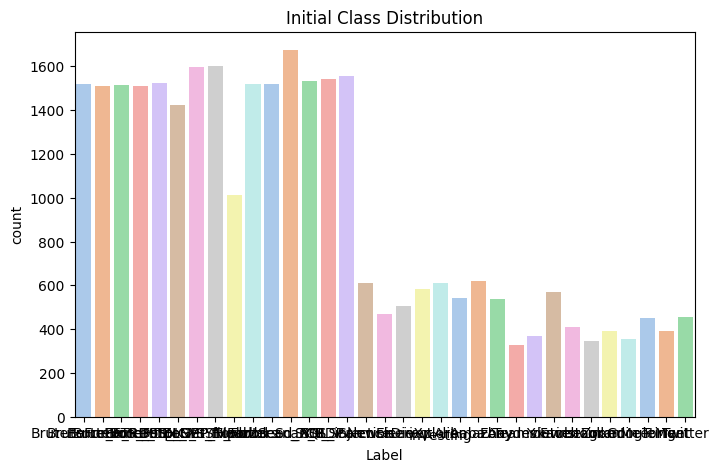

In [3]:
# Plot Initial Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df.iloc[:, -1], palette="pastel")
plt.title("Initial Class Distribution")
plt.show()

In [4]:
#Handle Missing Values
df = df.dropna()
print("\nAfter Dropping Missing Values:", df.shape)


After Dropping Missing Values: (30967, 80)


In [5]:
# Handle Outliers (IQR Method)
Q1 = df.select_dtypes(include=['number']).quantile(0.25)
Q3 = df.select_dtypes(include=['number']).quantile(0.75)
IQR = Q3 - Q1

df = df[~((df.select_dtypes(include=['number']) < (Q1 - 1.5 * IQR)) | 
          (df.select_dtypes(include=['number']) > (Q3 + 1.5 * IQR))).any(axis=1)]
print("\nAfter Removing Outliers:", df.shape)




After Removing Outliers: (2860, 80)


In [6]:
#Encode Categorical Variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].astype(str)  # Convert to string
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("\nAfter Encoding Categorical Variables:", df.shape)



After Encoding Categorical Variables: (2860, 80)


In [7]:
# Define Features (X) and Target (y)
target_col = df.columns[-1]  
X = df.drop(columns=[target_col])  
y = df[target_col]  


In [8]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (2288, 79)
Testing Set Shape: (572, 79)


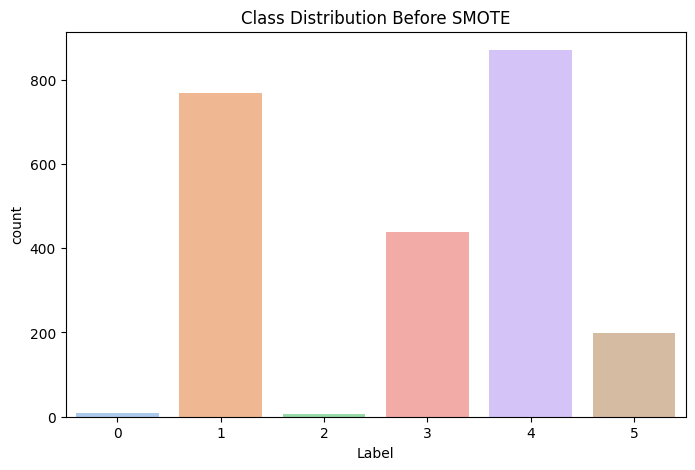


After SMOTE (Resampling for Class Imbalance): (5220, 79)


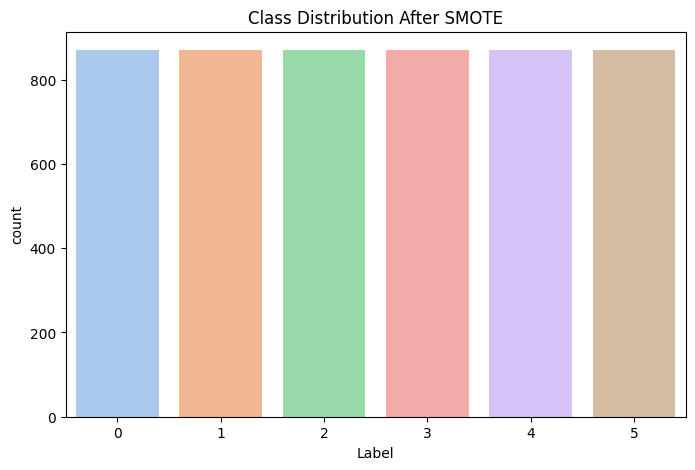

In [9]:
# Plot Class Distribution Before SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette="pastel")
plt.title("Class Distribution Before SMOTE")
plt.show()

#Apply SMOTE for Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE (Resampling for Class Imbalance):", X_resampled.shape)

#Plot Class Distribution After SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled, palette="pastel")
plt.title("Class Distribution After SMOTE")
plt.show()


In [10]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)  # Convert back to DataFrame
print("\nAfter Standard Scaling:", X_scaled.shape)




After Standard Scaling: (5220, 79)



After Removing Highly Correlated Features (26 dropped): (2860, 54)


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


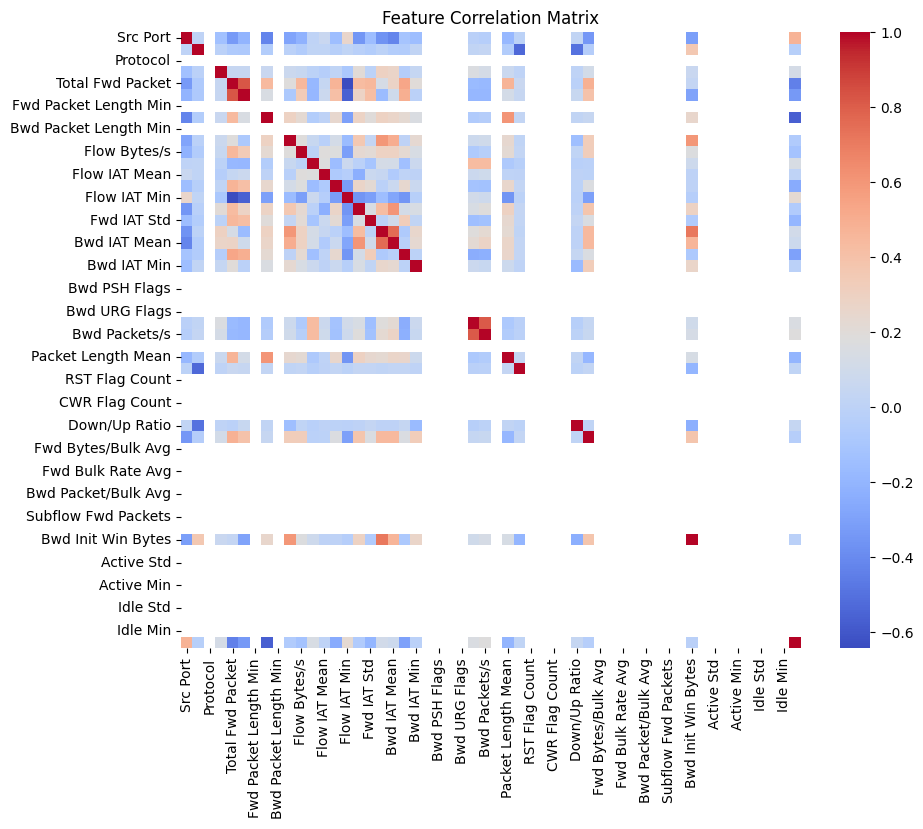


✅ Final Preprocessed Data Shape: (2860, 54)


In [11]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Only print dropped features if any exist
if to_drop:
    df = df.drop(columns=to_drop)
    print(f"\nAfter Removing Highly Correlated Features ({len(to_drop)} dropped):", df.shape)
else:
    print("\nNo Highly Correlated Features Found.")

# 📊 Plot Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

print("\n✅ Final Preprocessed Data Shape:", df.shape)


Boosting Algorithms

In [12]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

boosting_algos = {
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42),
    
    # Additional Boosting Algorithms
    'Stochastic Gradient Boosting (SGD)': SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=42),
    'XGBoost Advanced': XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42),
    'LightGBM Advanced': LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=7, num_leaves=31, random_state=42, verbose=-1),
    'CatBoost Advanced': CatBoostClassifier(iterations=200, learning_rate=0.05, depth=8, verbose=0, random_state=42),
    'LogitBoost': LogisticRegression(max_iter=1000, random_state=42),
    'Deep Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

# Cross-validation on boosting algorithms
for algo_name, algo in boosting_algos.items():
    print(f"\nTraining and evaluating {algo_name}...")
    
    # Cross-validation on training data (using resampled data from SMOTE)
    cv_scores = cross_val_score(algo, X_resampled, y_resampled, cv=5, scoring='accuracy')
    
    # Store results
    results[algo_name] = cv_scores
    print(f"{algo_name} Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Display final results
print("\nFinal Results of Boosting Algorithms:")
for algo_name, scores in results.items():
    print(f"{algo_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")



Training and evaluating AdaBoost...
AdaBoost Cross-Validation Accuracy: 0.5000 ± 0.0000

Training and evaluating GradientBoosting...
GradientBoosting Cross-Validation Accuracy: 0.9950 ± 0.0090

Training and evaluating HistGradientBoosting...
HistGradientBoosting Cross-Validation Accuracy: 0.9956 ± 0.0079

Training and evaluating XGBoost...
XGBoost Cross-Validation Accuracy: 0.9964 ± 0.0068

Training and evaluating LightGBM...
LightGBM Cross-Validation Accuracy: 0.9973 ± 0.0045

Training and evaluating CatBoost...
CatBoost Cross-Validation Accuracy: 0.9943 ± 0.0115

Training and evaluating Stochastic Gradient Boosting (SGD)...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

Stochastic Gradient Boosting (SGD) Cross-Validation Accuracy: 0.1667 ± 0.0000

Training and evaluating XGBoost Advanced...
XGBoost Advanced Cross-Validation Accuracy: 0.9992 ± 0.0011

Training and evaluating LightGBM Advanced...
LightGBM Advanced Cross-Validation Accuracy: 0.9975 ± 0.0041

Training and evaluating CatBoost Advanced...
CatBoost Advanced Cross-Validation Accuracy: 0.9946 ± 0.0107

Training and evaluating LogitBoost...
LogitBoost Cross-Validation Accuracy: 0.1667 ± 0.0000

Training and evaluating Deep Forest...
Deep Forest Cross-Validation Accuracy: 0.9975 ± 0.0028

Final Results of Boosting Algorithms:
AdaBoost: 0.5000 ± 0.0000
GradientBoosting: 0.9950 ± 0.0090
HistGradientBoosting: 0.9956 ± 0.0079
XGBoost: 0.9964 ± 0.0068
LightGBM: 0.9973 ± 0.0045
CatBoost: 0.9943 ± 0.0115
Stochastic Gradient Boosting (SGD): 0.1667 ± 0.0000
XGBoost Advanced: 0.9992 ± 0.0011
LightGBM Advanced: 0.9975 ± 0.0041
CatBoost Advanced: 0.9946 ± 0.0107
LogitBoost: 0.1667 ± 0.0000
Deep Forest: 0.99

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grids for each boosting model
param_grids = {
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'HistGradientBoosting': {
        'max_iter': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [4, 6, 8]
    },
    'Stochastic Gradient Boosting (SGD)': {
        'loss': ['log_loss', 'hinge'],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [1000, 2000]
    },
    'XGBoost Advanced': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 7, 10],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LightGBM Advanced': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'max_depth': [5, 7, 10]
    },
    'CatBoost Advanced': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [6, 8, 10]
    },
    'LogitBoost': {
        'C': [0.1, 1, 10],
        'max_iter': [100, 500, 1000]
    },
    'Deep Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    }
}

# Dictionary to store best models and best accuracies
best_models = {}
best_accuracies = {}

# Perform hyperparameter tuning
for algo_name, param_grid in param_grids.items():
    print(f"\nTuning hyperparameters for {algo_name}...")

    # Initialize the model
    model = boosting_algos[algo_name]

    # Use RandomizedSearchCV for faster tuning
    random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    
    # Fit the model
    random_search.fit(X_resampled, y_resampled)

    # Store the best model
    best_models[algo_name] = random_search.best_estimator_
    
    # Store the best cross-validation accuracy
    best_accuracies[algo_name] = random_search.best_score_

    # Print best parameters and accuracy
    print(f"Best parameters for {algo_name}: {random_search.best_params_}")
    print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

# Print final results
print("\nFinal Results of Boosting Algorithms:")
for algo_name, accuracy in best_accuracies.items():
    print(f"{algo_name}: {accuracy:.4f} ± {np.std(cross_val_score(best_models[algo_name], X_resampled, y_resampled, cv=5)):.4f}")



Tuning hyperparameters for AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for AdaBoost: {'n_estimators': 50, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.8272

Tuning hyperparameters for GradientBoosting...
Best parameters for GradientBoosting: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9952

Tuning hyperparameters for HistGradientBoosting...
Best parameters for HistGradientBoosting: {'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.01}
Best cross-validation accuracy: 0.9960

Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best cross-validation accuracy: 0.9989

Tuning hyperparameters for LightGBM...
Best parameters for LightGBM: {'num_leaves': 31, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9973

Tuning hyperparameters for CatBoost...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for CatBoost: {'learning_rate': 0.01, 'iterations': 100, 'depth': 6}
Best cross-validation accuracy: 0.9977

Tuning hyperparameters for Stochastic Gradient Boosting (SGD)...
Best parameters for Stochastic Gradient Boosting (SGD): {'max_iter': 1000, 'loss': 'hinge', 'alpha': 0.01}
Best cross-validation accuracy: 0.1667

Tuning hyperparameters for XGBoost Advanced...
Best parameters for XGBoost Advanced: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best cross-validation accuracy: 0.9992

Tuning hyperparameters for LightGBM Advanced...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for LightGBM Advanced: {'num_leaves': 50, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
Best cross-validation accuracy: 0.9975

Tuning hyperparameters for CatBoost Advanced...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for CatBoost Advanced: {'learning_rate': 0.01, 'iterations': 100, 'depth': 8}
Best cross-validation accuracy: 0.9987

Tuning hyperparameters for LogitBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for LogitBoost: {'max_iter': 100, 'C': 0.1}
Best cross-validation accuracy: 0.1667

Tuning hyperparameters for Deep Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Deep Forest: {'n_estimators': 200, 'max_depth': None}
Best cross-validation accuracy: 0.9990

Final Results of Boosting Algorithms:
AdaBoost: 0.8272 ± 0.0076
GradientBoosting: 0.9952 ± 0.0087
HistGradientBoosting: 0.9960 ± 0.0071
XGBoost: 0.9989 ± 0.0023
LightGBM: 0.9973 ± 0.0049
CatBoost: 0.9977 ± 0.0022
Stochastic Gradient Boosting (SGD): 0.1667 ± 0.0000
XGBoost Advanced: 0.9992 ± 0.0011
LightGBM Advanced: 0.9975 ± 0.0041
CatBoost Advanced: 0.9987 ± 0.0017
LogitBoost: 0.1667 ± 0.0000
Deep Forest: 0.9990 ± 0.0012


Model Comparison

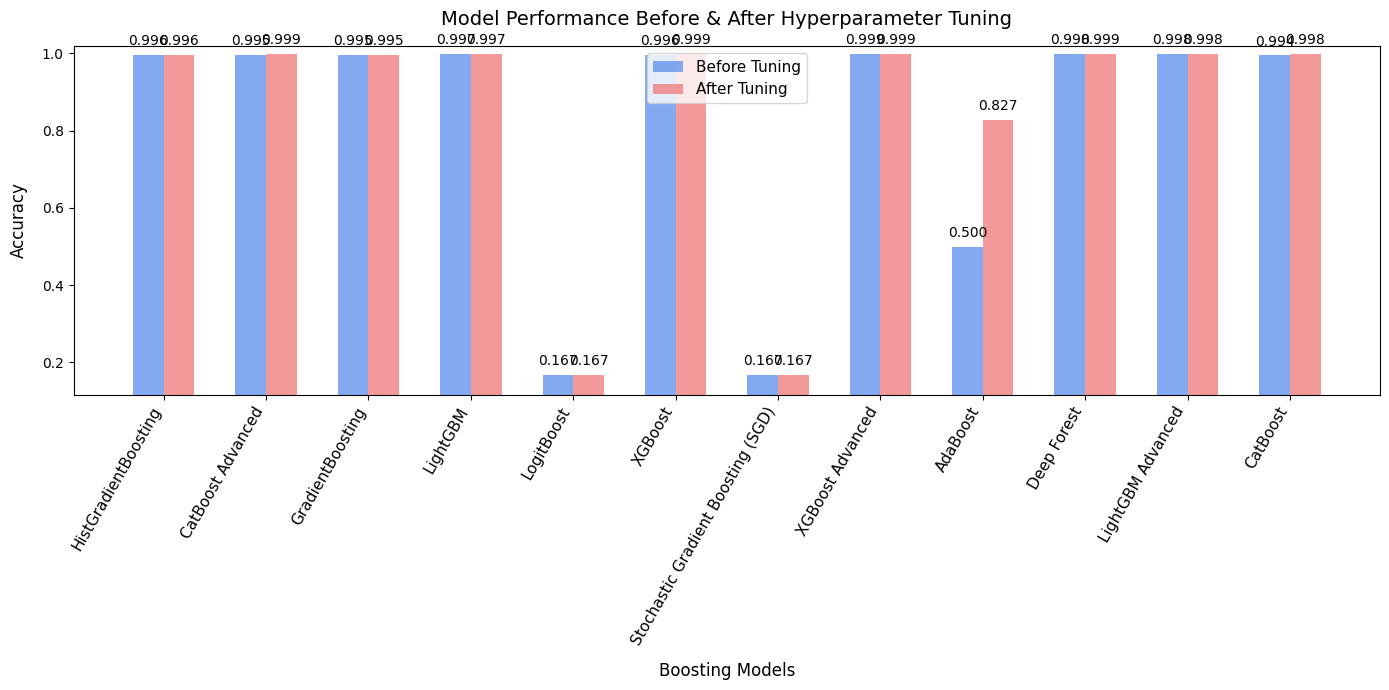

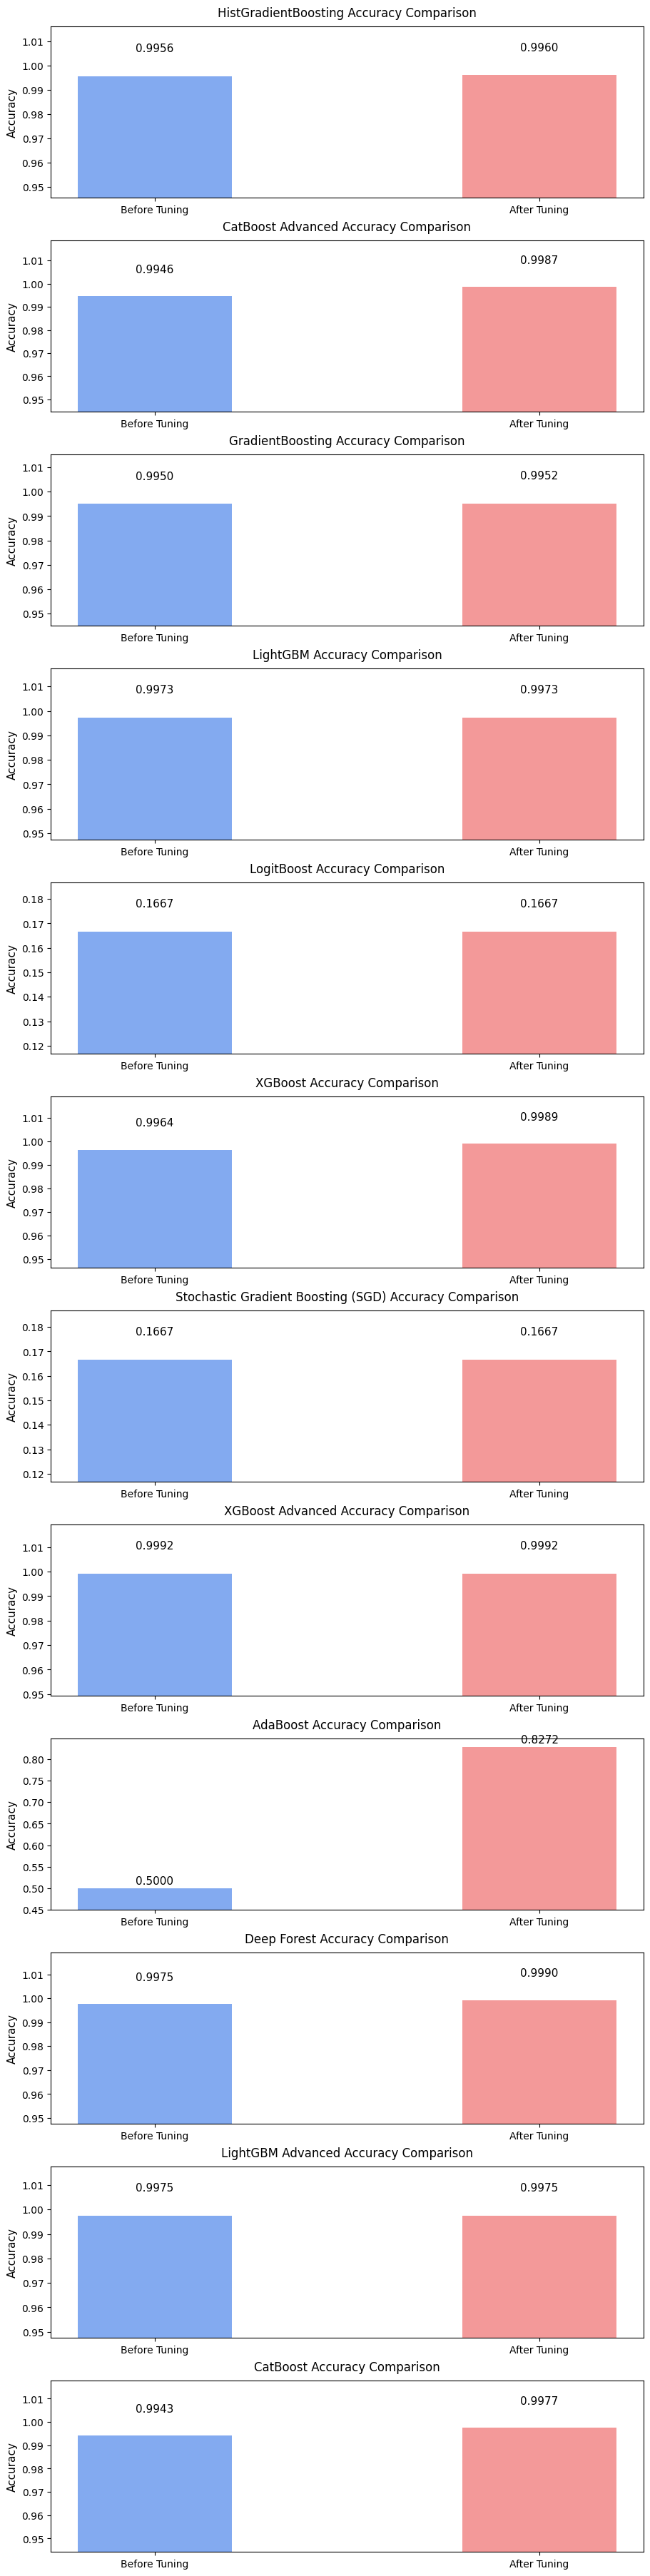

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract before tuning accuracy from cross-validation results
before_tuning = {algo: np.mean(scores) for algo, scores in results.items()}

# Extract after tuning accuracy from the best cross-validation scores
after_tuning = best_accuracies  # Use best_accuracies from RandomizedSearchCV results

# Ensure both have the same models
common_models = list(before_tuning.keys() & after_tuning.keys())

# Convert to lists for plotting
before_values = [before_tuning[m] for m in common_models]
after_values = [after_tuning[m] for m in common_models]

# Set up grouped bar plot for overall comparison
fig, ax = plt.subplots(figsize=(14, 7))  # Increased figure size for clarity
x = np.arange(len(common_models))  # X-axis positions
width = 0.3  # Reduced bar width for better spacing

bars1 = ax.bar(x - width/2, before_values, width, label='Before Tuning', color='cornflowerblue', alpha=0.8)
bars2 = ax.bar(x + width/2, after_values, width, label='After Tuning', color='lightcoral', alpha=0.8)

# Labels & Titles
ax.set_xlabel("Boosting Models", fontsize=12, labelpad=10)
ax.set_ylabel("Accuracy", fontsize=12, labelpad=10)
ax.set_title("Model Performance Before & After Hyperparameter Tuning", fontsize=14, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(common_models, rotation=60, ha='right', fontsize=11)  # Rotate x-axis labels
ax.legend(fontsize=11)

# Adjust y-axis dynamically
min_acc = min(before_values + after_values)
max_acc = max(before_values + after_values)
ax.set_ylim(min_acc - 0.05, max_acc + 0.02)  # Adds margin for readability

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Adjusted spacing to avoid overlap
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# --------------------------
# **Individual Model Comparison Subplots**
# --------------------------
fig, axes = plt.subplots(len(common_models), 1, figsize=(9, len(common_models) * 3), constrained_layout=True)

for i, model in enumerate(common_models):
    ax = axes[i] if len(common_models) > 1 else axes  # Handle single case
    before = before_tuning[model]
    after = after_tuning[model]
    
    ax.bar(["Before Tuning", "After Tuning"], [before, after], 
           color=["cornflowerblue", "lightcoral"], alpha=0.8, width=0.4)
    
    ax.set_title(f"{model} Accuracy Comparison", fontsize=12, pad=10)
    
    # Dynamically adjust y-scale with margin
    min_value = min(before, after)
    max_value = max(before, after)
    ax.set_ylim(min_value - 0.05, max_value + 0.02)

    ax.set_ylabel("Accuracy", fontsize=11)
    
    # Annotate values with spacing for better visibility
    for j, value in enumerate([before, after]):
        ax.text(j, value + 0.01, f"{value:.4f}", ha="center", fontsize=11, color='black')

plt.show()


ROC curve

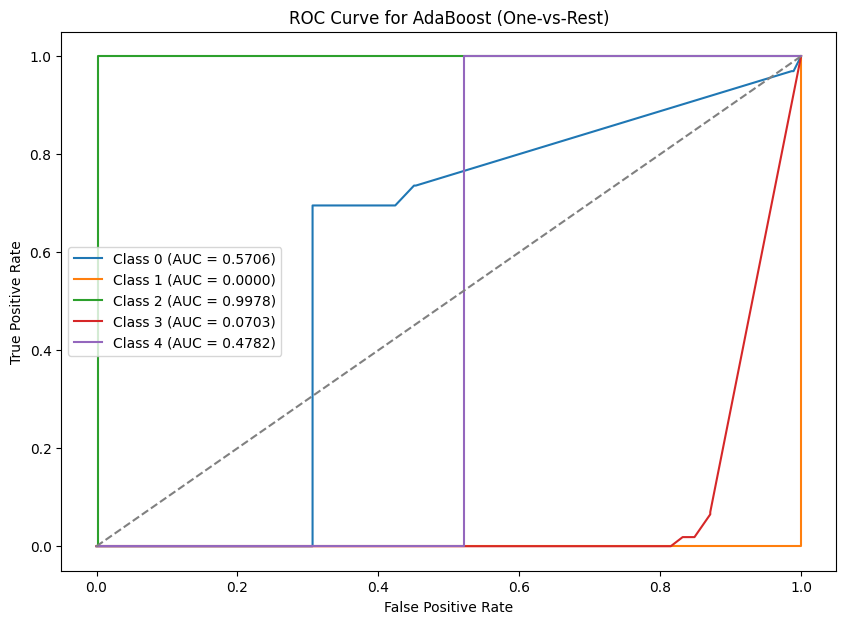

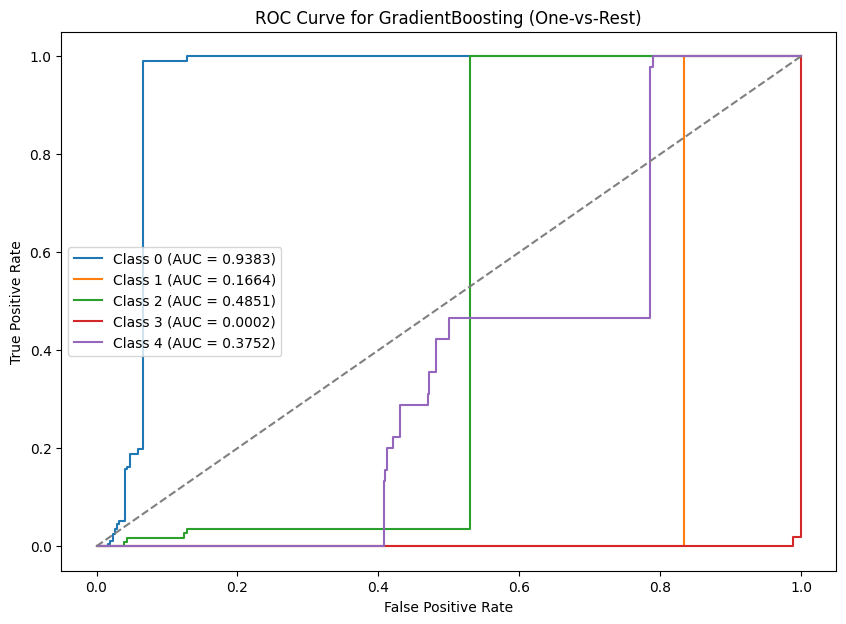

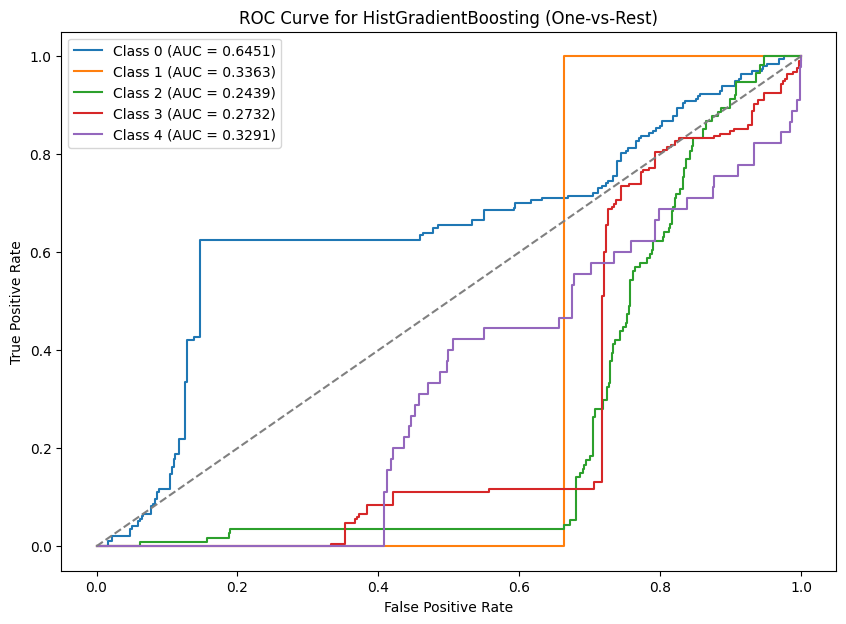

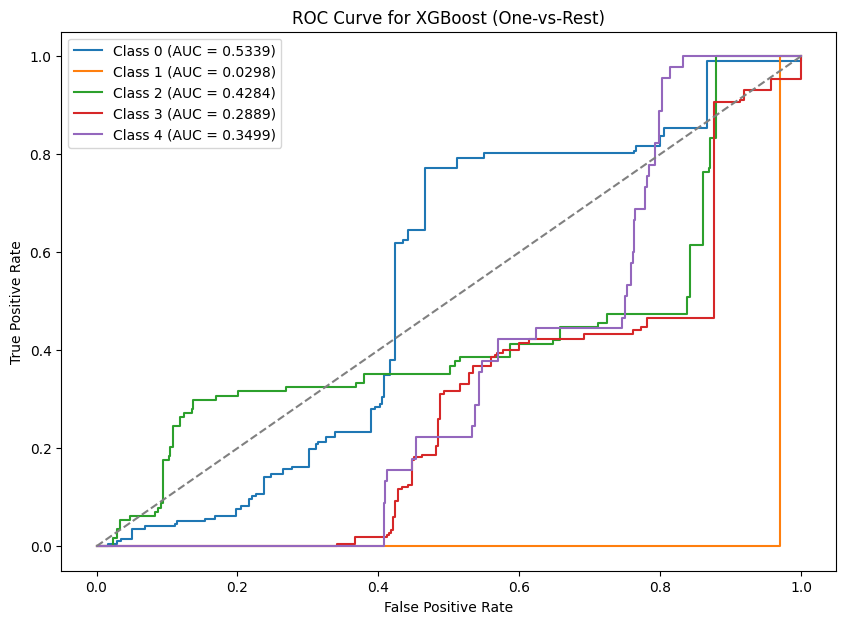

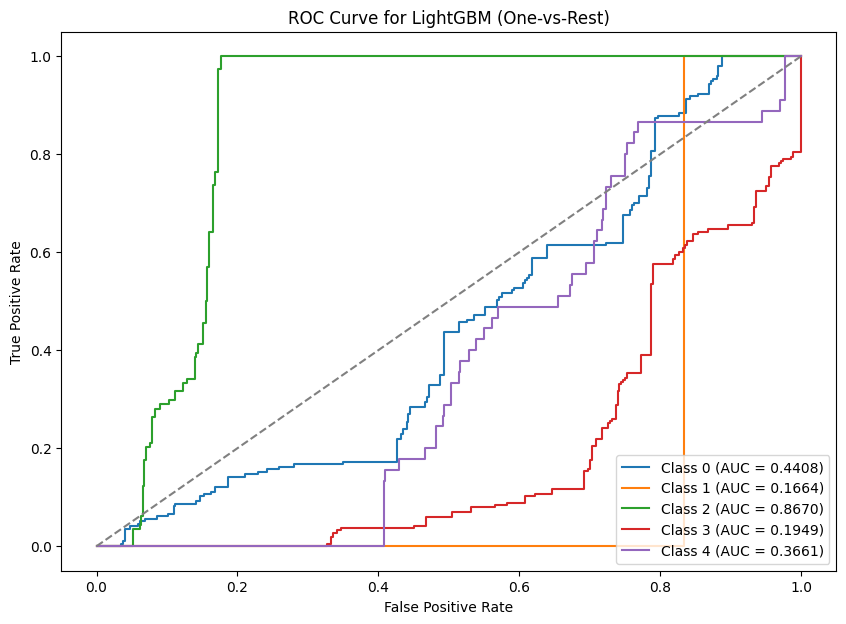

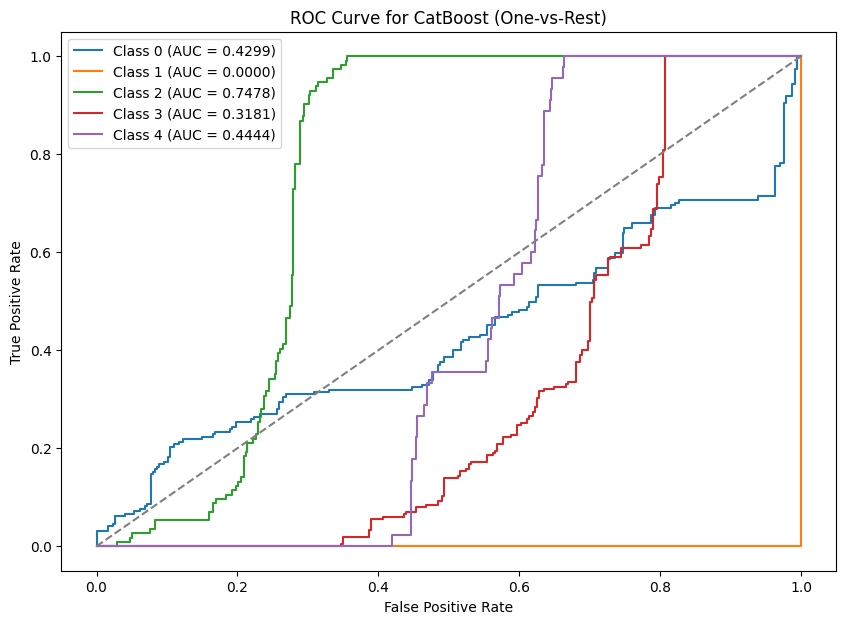

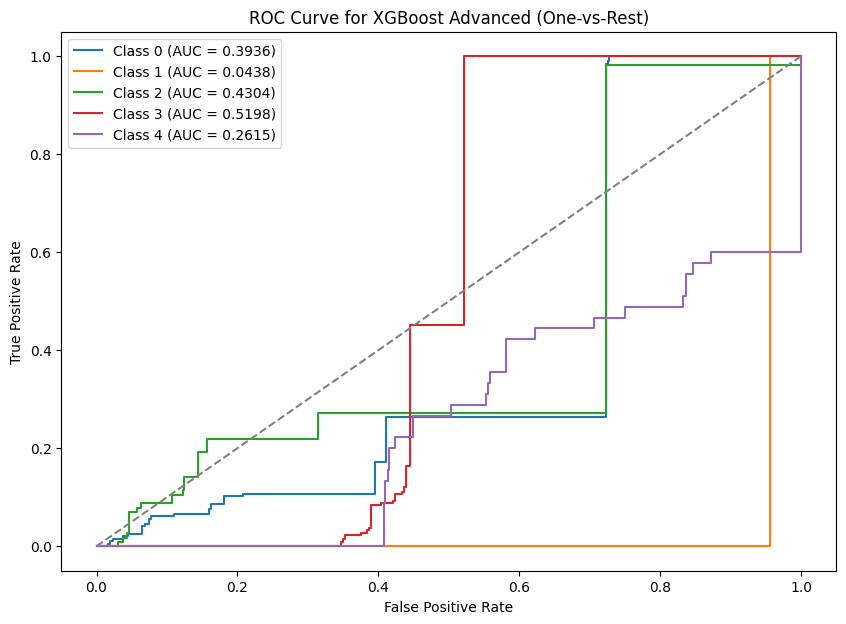

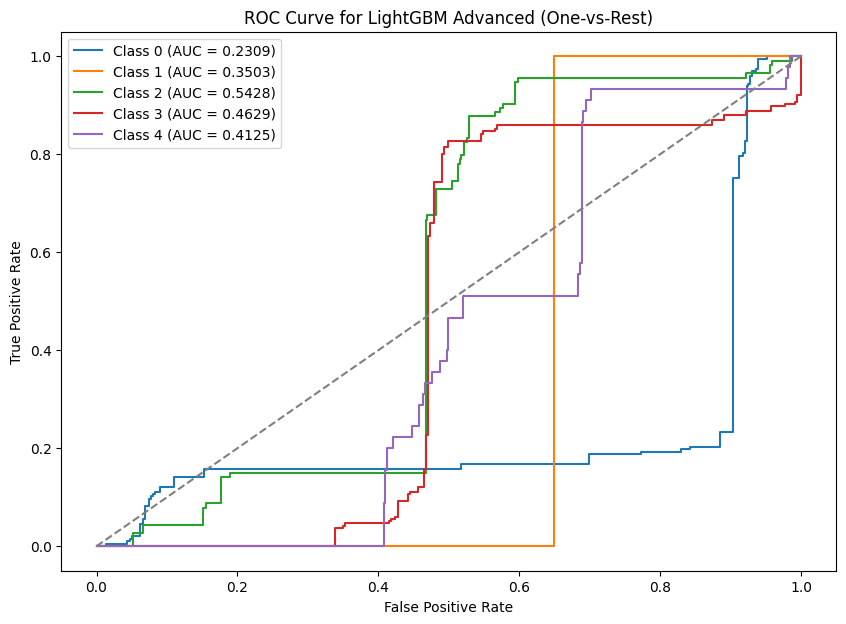

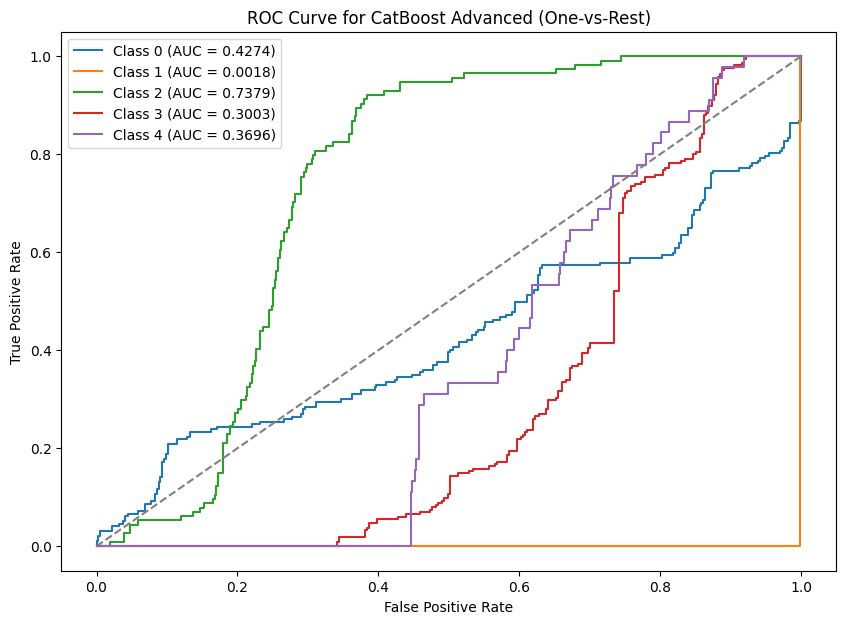

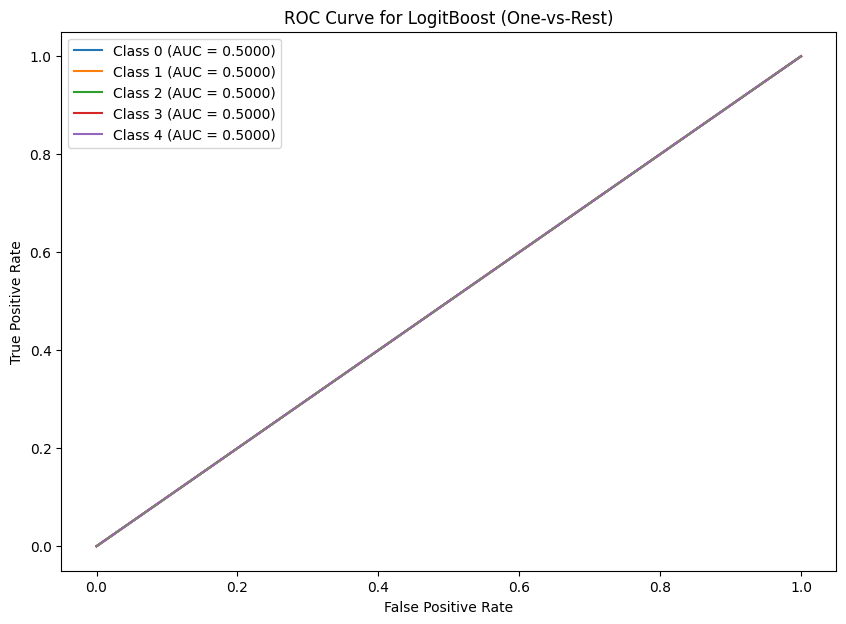

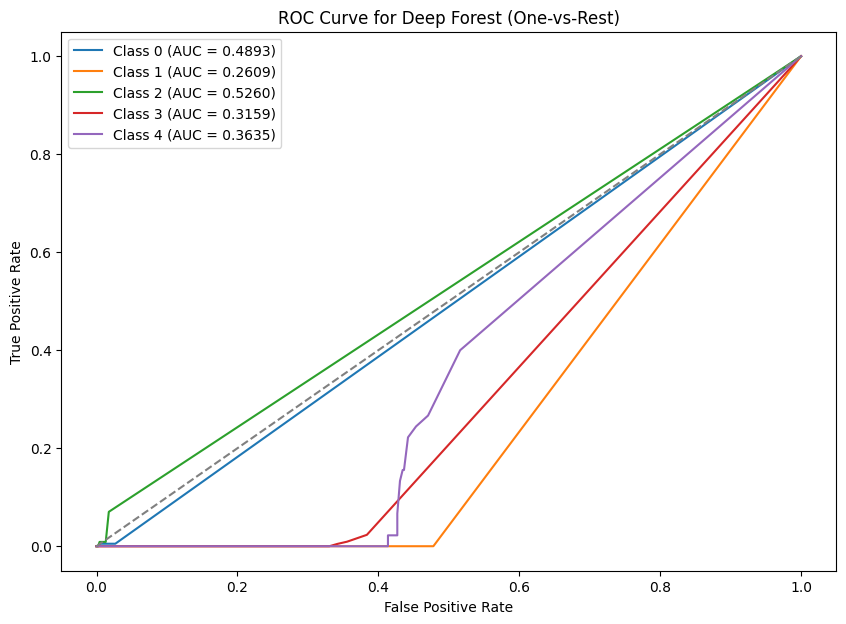

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels (One-vs-Rest approach)
n_classes = len(set(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=list(set(y_test)))

# Iterate over each model separately
for algo_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)

        plt.figure(figsize=(10, 7))

        # Compute ROC curve and AUC for each class
        for class_idx in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_pred_proba[:, class_idx])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {roc_auc:.4f})")

        # Plot diagonal reference line
        plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {algo_name} (One-vs-Rest)")
        plt.legend()
        plt.show()


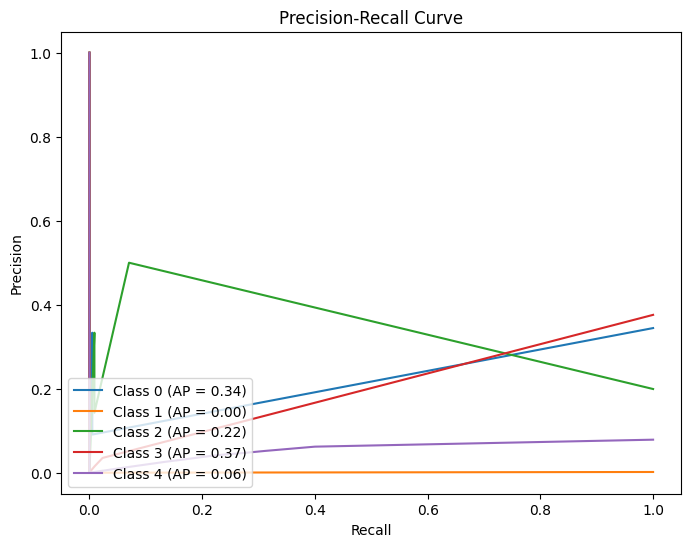

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


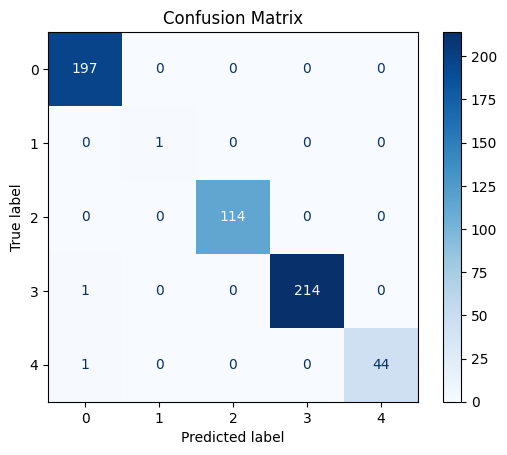

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predicted class labels (argmax of probabilities)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


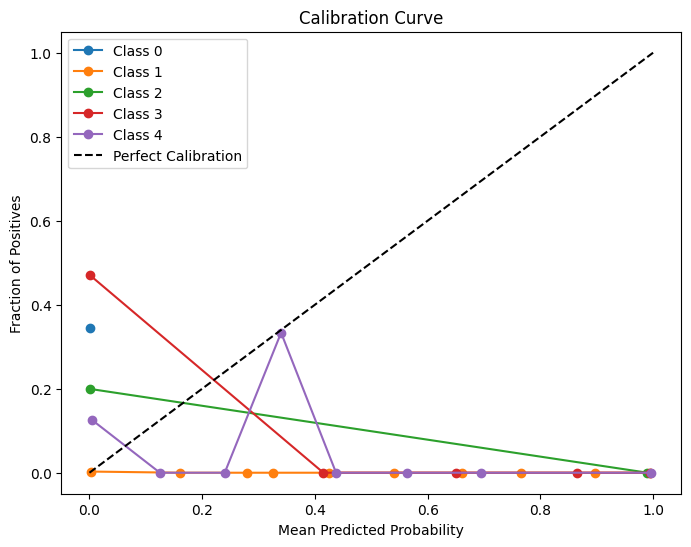

In [18]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_test_bin[:, i], y_pred_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


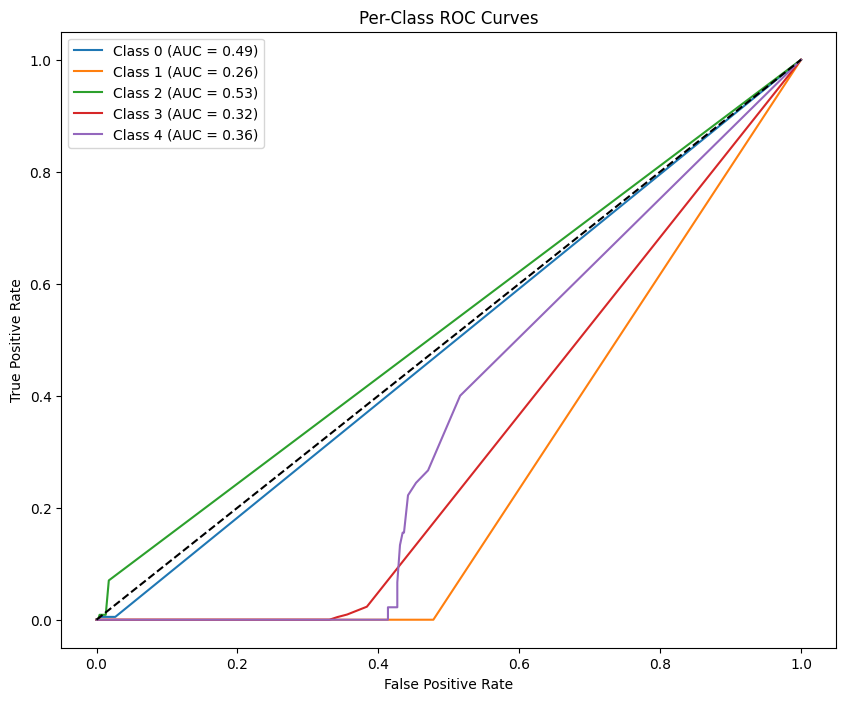

In [19]:
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Per-Class ROC Curves")
plt.legend()
plt.show()


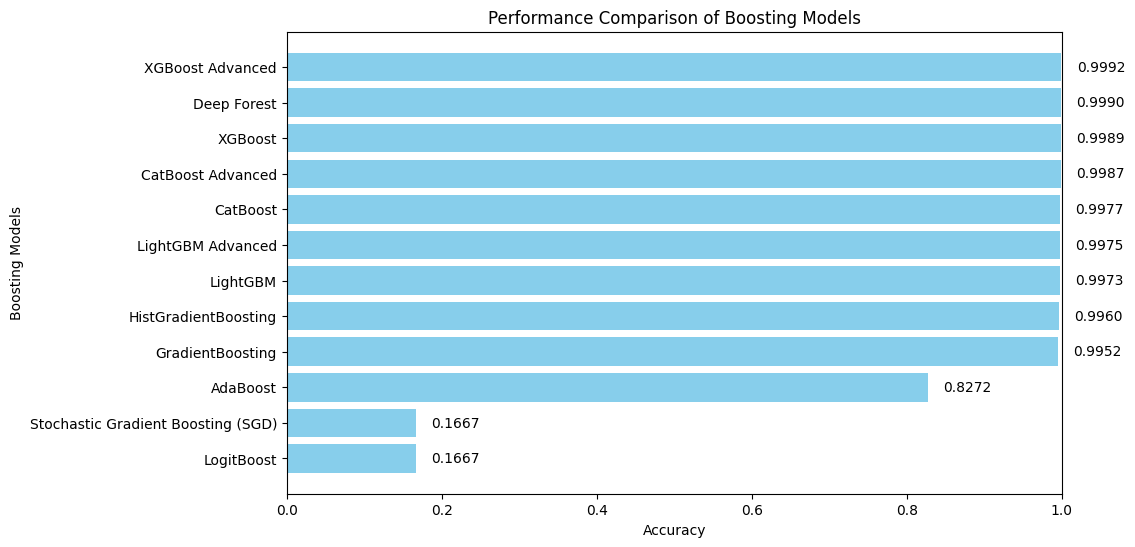

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Sorting models by accuracy
sorted_models = sorted(best_accuracies.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*sorted_models)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Boosting Models')
plt.title('Performance Comparison of Boosting Models')
plt.xlim(0, 1)  # Accuracy range from 0 to 1
plt.gca().invert_yaxis()  # Highest accuracy on top

# Display accuracy values on bars
for index, value in enumerate(accuracies):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center', fontsize=10)

plt.show()


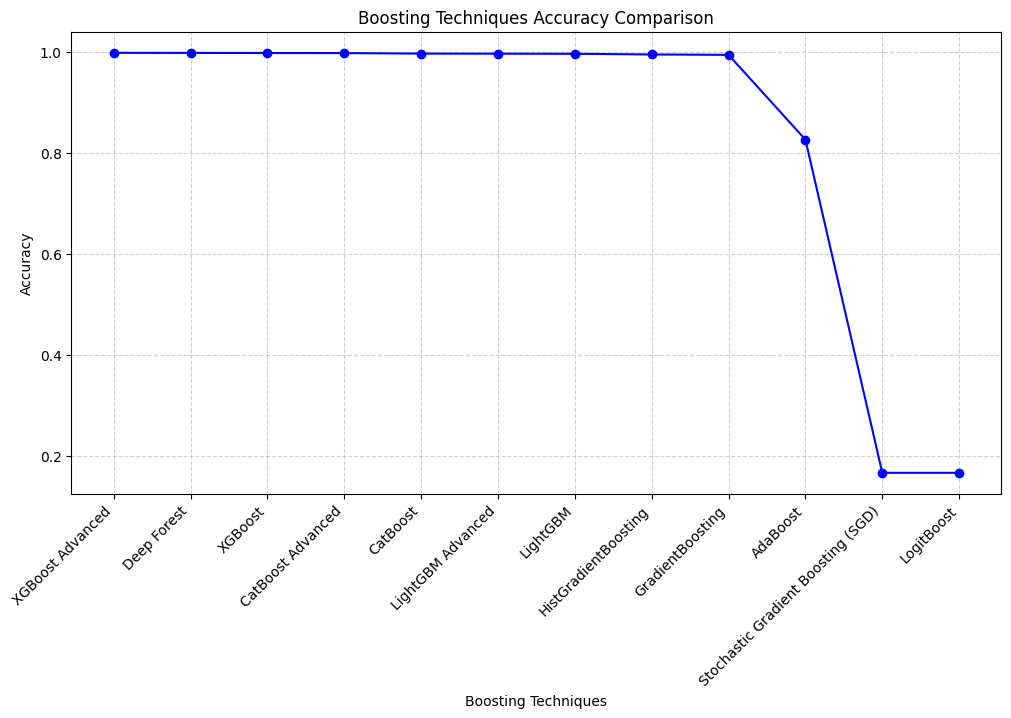

In [22]:
import matplotlib.pyplot as plt

# Sorting models by accuracy
sorted_models = sorted(best_accuracies.items(), key=lambda x: x[1], reverse=True)
models, accuracies = zip(*sorted_models)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(models, accuracies, marker='o', linestyle='-', color='b', markersize=6)

# Labels and title
plt.xlabel('Boosting Techniques')
plt.ylabel('Accuracy')
plt.title('Boosting Techniques Accuracy Comparison')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()
